In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
#from category_encoders import TargetEncoder
from pandas.api.types import CategoricalDtype

In [4]:
# Leer el JSON
df_91_20 = pd.read_json('df_91_20.json', orient='records', lines=True)

df_91_20.head()

,Estación,Mes,Precipitación,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Viento,Temperatura,Temperatura Máx.,Temperatura Mín.,Viento_medido
0,AEROPARQUE AERO,Abr,108.3,6.6,73.6,3.5,13.9,18.5,22.0,15.3,True
1,AEROPARQUE AERO,Ago,61.5,5.0,73.6,3.9,14.0,12.9,16.5,9.7,True
2,AEROPARQUE AERO,Dic,112.8,6.6,65.1,3.2,15.9,23.2,27.4,19.2,True
3,AEROPARQUE AERO,Ene,117.5,6.7,67.0,3.1,16.8,24.5,28.4,20.8,True
4,AEROPARQUE AERO,Feb,112.3,6.0,69.8,3.2,15.8,23.7,27.3,20.2,True


### Variable Target

Para abordar el problema como una tarea de clasificación, se definió como variable objetivo la temperatura media anual de cada estación, representada por la variable 'Temperatura'. A partir de su valor promedio anual, se clasificaron las estaciones meteorológicas en cuatro categorías:

Frías: promedio menor a 10 °C

Templadas frescas: entre 10 °C y 15 °C

Templadas cálidas: entre 15 °C y 20 °C

Cálidas: promedio mayor a 20 °C

Esta clasificación busca representar de manera más precisa la variabilidad climática del país. A continuación, se agruparon las observaciones por estación y se asignó una etiqueta a cada una según el promedio de temperatura.

In [5]:
# Agrupamos por estación y calculamos el promedio de temperatura

df_temperatura_estacion = df_91_20.groupby("Estación")["Temperatura"].mean().reset_index()

# Creamos la variable target

def clasificar_temp(temperatura):
    if temperatura < 10:
        return "fría"
    elif temperatura < 15:
        return "templada fresca"
    elif temperatura < 20:
        return "templada cálida"
    else:
        return "cálida"

df_temperatura_estacion["CLASE"] = df_temperatura_estacion["Temperatura"].apply(clasificar_temp)

In [6]:
print(df_temperatura_estacion["CLASE"].value_counts())

CLASE
templada cálida    50
templada fresca    19
fría               15
cálida             14
Name: count, dtype: int64


Se nota un fuerte desbalance de clases siendo la clase "templada cálida" fuertemente predominante. Graficamos para mayor claridad: 

C:\Users\matim\AppData\Local\Temp\ipykernel_6404\3751032074.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_temperatura_estacion, x="CLASE", palette="coolwarm")


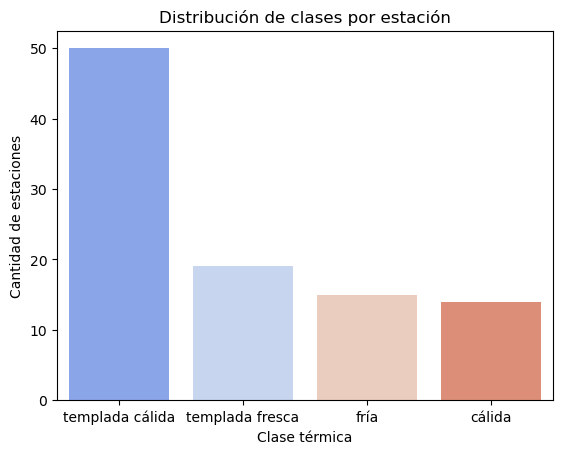

In [7]:
sns.countplot(data=df_temperatura_estacion, x="CLASE", palette="coolwarm")
plt.title("Distribución de clases por estación")
plt.xlabel("Clase térmica")
plt.ylabel("Cantidad de estaciones")
plt.show()

Para corregir este sobremuestreo elegimos aplicar un SMOTE a las clases minoritarias en lugar de un submuestreo de la clase mayoritaria ya que nos permite conservar mayor cantidad de datos y ayuda a evitar el overfitting.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Definimos variables numéricas y categóricas
numericas = df_temperatura_estacion.select_dtypes(include='number').drop(columns=["Temperatura"]).columns.tolist()
categoricas = df_temperatura_estacion.select_dtypes(include='object').drop(columns=["CLASE"]).columns.tolist()

# Pipelines para imputación y encoding
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer para las variables numéricas y categóricas
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numericas),
    ("cat", categorical_pipeline, categoricas)
])

# Preprocesamiento
X = df_temperatura_estacion.drop(columns=["CLASE"])
y = df_temperatura_estacion["CLASE"]

X_prep = preprocessor.fit_transform(X)

# SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_prep, y)

#Vemos cómo quedó
print(y_res.value_counts())

CLASE
templada cálida    50
templada fresca    50
fría               50
cálida             50
Name: count, dtype: int64


Luego de aplicar SMOTE vemos que ahora las clases están balanceadas con 50 casos cada una. 